In [1]:
import csv
import json
import feather # pip install feather-format
import numpy as np
import pandas as pd
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import geopandas as gpd
import ast
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
%matplotlib inline


In [2]:
## Some utility functions
def percentToInt(percentString):
    return int(percentString.rstrip("%"))
def trueFalseToBinary(tfstring):
    return 1 if tfstring=='t' else '0'
def stringListToList(stringList):
    return ast.literal_eval(stringList)
def stringListToCount(stringList):
    return len(ast.literal_eval(stringList))

# importing the data


In [3]:
reviews_data_path = "data/reviews.csv"
listings_data_path = "data/listings.csv"
calendar_data_path = "data/calendar.csv"
neighbors_data_path = "data/neighbourhoods.csv"
neighbors_geojson_path = "data/neighbourhoods.geojson"

def convert_to_feather(csvfilepath):
    df = pd.read_csv(csvfilepath)
    filename_no_ext = os.path.split(os.path.splitext(csvfilepath)[0])[1]
    filepath_feather = "feather/"+filename_no_ext+".feather"
    feather.write_dataframe(df, filepath_feather)
    print(filepath_feather, "is converted/written")

# # Convert to feather: Single execution
# for csvfilepath in [reviews_data_path, listings_data_path, calendar_data_path]:
#     convert_to_feather(csvfilepath)


## Data from feather

In [4]:
reviews_data_path = "feather/reviews.feather"
listings_data_path = "feather/listings.feather"
calendar_data_path = "feather/calendar.feather"

reviews_data = pd.read_feather(reviews_data_path)
listings_data = pd.read_feather(listings_data_path)
calendar_data = pd.read_feather(calendar_data_path)

## Reviews Data

In [5]:
print("reviews data shape", reviews_data.shape)
reviews_data.head()

reviews data shape (115655, 6)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,3781,37776825,2015-07-10,36059247,Greg,The apartment was as advertised and Frank was ...
1,3781,41842494,2015-08-09,10459388,Tai,It was a pleasure to stay at Frank's place. Th...
2,3781,45282151,2015-09-01,12264652,Damien,The apartment description is entirely faithful...
3,3781,49022647,2015-09-30,41426327,Mike,Thoroughly enjoyed my time at Frank's home. Ha...
4,3781,52503327,2015-10-30,15151513,Ivan,Great value for the money! This location has e...


## Listing Data

In [6]:
print("Listings data shape", listings_data.shape)
listings_data.head()

Listings data shape (3043, 74)


,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3781,https://www.airbnb.com/rooms/3781,20210712150755,2021-07-12,HARBORSIDE-Walk to subway,Fully separate apartment in a two apartment bu...,"Mostly quiet ( no loud music, no crowed sidewa...",https://a0.muscache.com/pictures/24670/b2de044...,4804,https://www.airbnb.com/users/show/4804,...,4.95,4.85,4.90,None,f,1,1,0,0,0.29
1,5506,https://www.airbnb.com/rooms/5506,20210712150755,2021-07-12,**Special ** Private! Minutes to center!,"Private guest room with private bath, You do n...","Peaceful, Architecturally interesting, histori...",https://a0.muscache.com/pictures/miso/Hosting-...,8229,https://www.airbnb.com/users/show/8229,...,4.89,4.52,4.78,Approved by the government,f,9,9,0,0,0.90
2,6695,https://www.airbnb.com/rooms/6695,20210712150755,2021-07-12,Special!! Home Away! Condo,"Comfortable, Fully Equipped private apartment...","Peaceful, Architecturally interesting, histori...",https://a0.muscache.com/pictures/38ac4797-e7a4...,8229,https://www.airbnb.com/users/show/8229,...,4.95,4.48,4.70,STR446650,f,9,9,0,0,1.37
3,10730,https://www.airbnb.com/rooms/10730,20210712150755,2021-07-12,Bright 1bed facing Golden Dome,"Bright, spacious unit, new galley kitchen, new...",Beacon Hill is located downtown and is conveni...,https://a0.muscache.com/pictures/miso/Hosting-...,26988,https://www.airbnb.com/users/show/26988,...,4.92,4.96,4.43,None,f,5,5,0,0,0.41
4,10813,https://www.airbnb.com/rooms/10813,20210712150755,2021-07-12,"Back Bay Apt-blocks to subway, Newbury St, The...",Stunning Back Bay furnished studio apartment. ...,Wander around this quintessential neighborhood...,https://a0.muscache.com/pictures/20b5b9c9-e1f4...,38997,https://www.airbnb.com/users/show/38997,...,5.00,5.00,4.75,None,f,11,11,0,0,0.18


## Calendar Data

In [7]:
print("calendar data shape", calendar_data.shape)
calendar_data.head()

calendar data shape (1110686, 7)


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,3781,2021-07-12,f,$125.00,$125.00,32,1125
1,1644031,2021-07-12,f,$100.00,$90.00,1,1125
2,1644031,2021-07-13,f,$100.00,$90.00,1,1125
3,1644031,2021-07-14,f,$100.00,$90.00,1,1125
4,1644031,2021-07-15,f,$100.00,$100.00,1,1125


# Data Cleaning

Data cleaning depending on needs
- Reviews Data can be used for word cloud
- Listings Data can be used for price prediction, heatmapping, 
- calendar data for exploring pricing changes over time/season/weekend, availability?

### features to develop
- closeness to landmarks
- season pricing
- weekend pricing
- availability as indicator of good pricing; avaialbility30 category indicates # of days available for next 30 days 
- onehot encode certain features
- for some features like minimum_nights, -> make them categorical then onehot; for example, min3 becomes short term, min10 medium term, min30 long term


### some considerations
- individual reviews has no review score; may require positive negative sentiment analysis depending on feature needs
- clustering different properties by rating categories and scores

In [8]:
print(reviews_data.dtypes)
print(reviews_data.shape)
# print(reviews_data.isnull().sum())
reviews_data = reviews_data.dropna()
print(reviews_data.shape)

listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object
(115655, 6)
(115572, 6)


In [9]:
print(listings_data.dtypes)
print(listings_data.shape)
listings_data['number_of_reviews'].isnull().sum() # No null value for column "number_of_reviews"


id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 74, dtype: object
(3043, 74)


0

## Listings Data feature selection
- manually pick out all relevant features for preprocessing
- remove rows where any feature is missing or incomplete -> df_none_null


In [10]:
# features necessary - delete rows with null
features_none_null = ["id","host_id","host_since","host_response_rate","host_acceptance_rate",
                        "host_response_time",
                        "host_is_superhost", "host_verifications",
                        "host_has_profile_pic", "host_identity_verified",
                        "neighbourhood_cleansed", "latitude", "longitude",
                        "room_type", "accommodates", "amenities", "price", "minimum_nights", 
                        "availability_30",	"availability_60",	"availability_90","availability_365", 
                        "number_of_reviews", "review_scores_rating", 
                        "review_scores_accuracy",	"review_scores_cleanliness",	"review_scores_checkin",	"review_scores_communication",
                        "review_scores_location",	"review_scores_value",
                        "instant_bookable", 
                        ]

df_none_null = listings_data.copy(deep = True)[features_none_null]

print("before droppign rows with null columns: ", df_none_null.shape)
for col in features_none_null:
    df_none_null = df_none_null[df_none_null[col].notna()]
    # print(col, df_none_null.shape)
print("after dropping rows with null columns: ", df_none_null.shape)

## most null columns - host_response_rate,review_scores general

before droppign rows with null columns:  (3043, 31)
after dropping rows with null columns:  (1678, 31)


### Feature Engineering - host_since to host_number_of_years (since date to data scraped date)

In [11]:
reference_date = datetime.datetime(2021,7,12)

# adding custom: host_number_of_years
host_number_of_years = [(reference_date - datetime.datetime.strptime(i, '%Y-%m-%d')).days/365
                        for i in df_none_null['host_since']]
df_none_null["host_number_of_years"] = host_number_of_years
df_none_null['price'] = df_none_null['price'].map(lambda x:float(x[1:].replace(',', '')))


## host experience (years) VS. ratings

<AxesSubplot:xlabel='host_number_of_years', ylabel='review_scores_rating'>

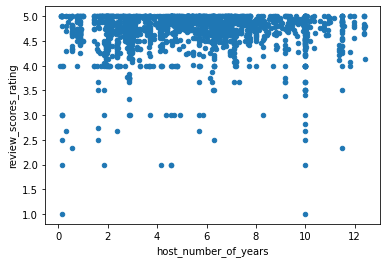

In [12]:
# number of host years VS. ratings/price
df_none_null.plot.scatter(x="host_number_of_years", y="review_scores_rating")

## host experience (years) VS. price

<AxesSubplot:xlabel='host_number_of_years', ylabel='price'>

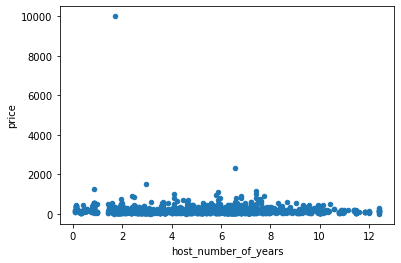

In [13]:
# number of host years VS. ratings/price
df_none_null.plot.scatter(x="host_number_of_years", y="price")

In [14]:
df_none_null.host_number_of_years.describe()

count    1678.000000
mean        5.509854
std         2.859154
min         0.073973
25%         2.964384
50%         5.695890
75%         7.164384
max        12.410959
Name: host_number_of_years, dtype: float64

(3.0, 5.0)

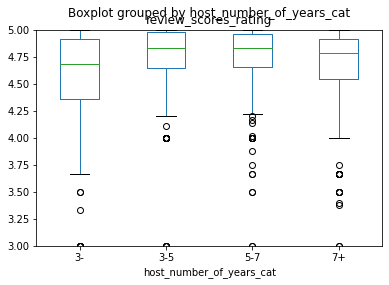

In [15]:
def categorize_years(year):
    if year>7:
        return "7+"
    if year>5:
        return "5-7"
    if year>3:
        return "3-5"
    else: return "3-"


df_none_null["host_number_of_years_cat"] = df_none_null["host_number_of_years"].map(categorize_years)

df_none_null.boxplot(by="host_number_of_years_cat", column=["review_scores_rating"], grid = False).set_ylim([3,5])

(0.0, 500.0)

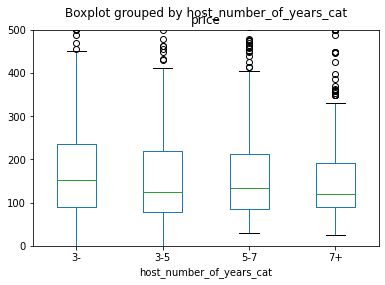

In [16]:

df_none_null.boxplot(by="host_number_of_years_cat", column=["price"], grid = False).set_ylim([0,500])

/Users/jingyu/.pyenv/versions/3.9.6/envs/lab4/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[(0.0, 300.0)]

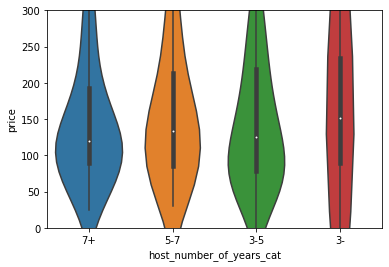

In [17]:
sns.violinplot("host_number_of_years_cat", "price", data=df_none_null).set(ylim=(0,300))

# neighborhood and pricing

/Users/jingyu/.pyenv/versions/3.9.6/envs/lab4/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[(0.0, 500.0), None]

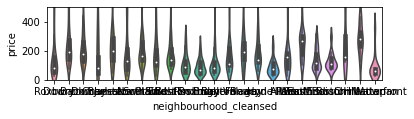

In [18]:
# neighbourhood_cleansed vs price
sns.violinplot("neighbourhood_cleansed", "price", data=df_none_null).set(ylim=(0,500),aspect=1/100)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

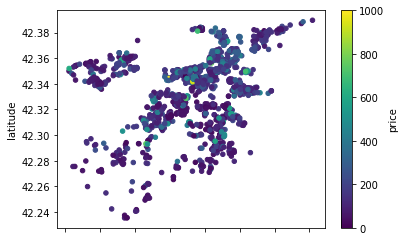

In [19]:
df_none_null = df_none_null[(np.abs(stats.zscore(df_none_null['price'])) < 3)]
df_none_null.plot.scatter(x="longitude",y="latitude", c="price",colormap='viridis')

/var/folders/89/dlgkzx7s06z_9t0lcl5wtj_w0000gp/T/ipykernel_13942/2208446452.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['availability_30'] = _df['availability_30']/30.0


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

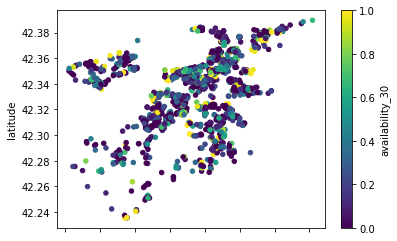

In [20]:
_df = df_none_null
_df['availability_30'] = _df['availability_30']/30.0
_df.plot.scatter(x="longitude",y="latitude", c="availability_30",colormap='viridis')

<AxesSubplot:>

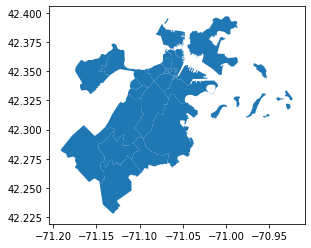

In [21]:
bostonGEO = gpd.read_file(neighbors_geojson_path)
bostonGEO.plot()

In [22]:
bostonGEO['neighbourhood'] #bostonGEO['geometry']

0                  Roslindale
1               Jamaica Plain
2                Mission Hill
3       Longwood Medical Area
4                 Bay Village
5            Leather District
6                   Chinatown
7                   North End
8                     Roxbury
9                   South End
10                   Back Bay
11                East Boston
12                Charlestown
13                   West End
14                Beacon Hill
15                   Downtown
16                     Fenway
17                   Brighton
18               West Roxbury
19                  Hyde Park
20                   Mattapan
21                 Dorchester
22    South Boston Waterfront
23               South Boston
24                    Allston
25             Harbor Islands
Name: neighbourhood, dtype: object

In [27]:
neighbourhoods_prices_mean =[]
neighbourhoods_prices_median =[]
neighbourhoods_prices_min =[]
neighbourhoods_prices_max =[]
neighbourhoods_prices_std =[]
neighbourhoods_prices_count =[]

for i in bostonGEO['neighbourhood']:
    df_neighbour = df_none_null[df_none_null["neighbourhood_cleansed"]==i]
    # print(df_neighbour.shape)
    print(df_neighbour['price'].mean())
    to_append = df_neighbour['price'].mean()
    neighbourhoods_prices_mean.append(to_append)

    to_append = df_neighbour['price'].median()
    neighbourhoods_prices_median.append(to_append)

    to_append = df_neighbour['price'].min()
    neighbourhoods_prices_min.append(to_append)

    to_append = df_neighbour['price'].max()
    neighbourhoods_prices_max.append(to_append)

    to_append = df_neighbour['price'].std()
    neighbourhoods_prices_std.append(to_append)

    to_append = df_neighbour['price'].count()
    neighbourhoods_prices_count.append(to_append)

bostonGEO['price']=neighbourhoods_prices_mean
bostonGEO['price_median']=neighbourhoods_prices_median
bostonGEO['price_min']=neighbourhoods_prices_min
bostonGEO['price_max']=neighbourhoods_prices_max
bostonGEO['price_std']=neighbourhoods_prices_std
bostonGEO['price_count']=neighbourhoods_prices_count


90.96875
176.87719298245614
128.03846153846155
nan
169.97142857142856
nan
282.05
193.7948717948718
139.35135135135135
179.43410852713177
220.94495412844037
139.8235294117647
215.32692307692307
239.3125
198.54666666666665
231.60106382978722
235.23728813559322
112.30232558139535
108.61111111111111
86.44
88.57142857142857
127.40182648401826
262.4117647058824
181.09195402298852
164.03076923076924
nan


<AxesSubplot:>

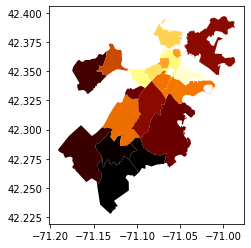

In [24]:
bostonGEO.plot(column='price', cmap='afmhot')

In [29]:
# neighborhood prices to JSON
import simplejson

dict_neighborAvgPrice = {}
for i, neighbourhood in enumerate(bostonGEO['neighbourhood']):
    to_append_dict ={}

    to_append_dict['price'] = bostonGEO['price'][i]
    to_append_dict['price_median'] = bostonGEO['price_median'][i]
    to_append_dict['price_min'] = bostonGEO['price_min'][i]
    to_append_dict['price_max'] = bostonGEO['price_max'][i]
    to_append_dict['price_std'] = bostonGEO['price_std'][i]
    # to_append_dict['price_count'] = bostonGEO['price_count'][i]


    # dict_neighborAvgPrice[neighbourhood]= bostonGEO['price'][i]
    dict_neighborAvgPrice[neighbourhood]= to_append_dict

print(dict_neighborAvgPrice)
# json_object = json.dumps(dict_neighborAvgPrice, indent = 4)
with open("data/neighbourhoods_prices_plus.json", "w") as outfile:
    simplejson.dump(dict_neighborAvgPrice, outfile, indent = 4, ignore_nan=True)


{'Roslindale': {'price': 90.96875, 'price_median': 68.5, 'price_min': 25.0, 'price_max': 250.0, 'price_std': 54.61211278556458}, 'Jamaica Plain': {'price': 176.87719298245614, 'price_median': 129.5, 'price_min': 29.0, 'price_max': 748.0, 'price_std': 150.88395238015283}, 'Mission Hill': {'price': 128.03846153846155, 'price_median': 106.5, 'price_min': 65.0, 'price_max': 300.0, 'price_std': 60.38111013834095}, 'Longwood Medical Area': {'price': nan, 'price_median': nan, 'price_min': nan, 'price_max': nan, 'price_std': nan}, 'Bay Village': {'price': 169.97142857142856, 'price_median': 112.0, 'price_min': 57.0, 'price_max': 548.0, 'price_std': 115.09778086333318}, 'Leather District': {'price': nan, 'price_median': nan, 'price_min': nan, 'price_max': nan, 'price_std': nan}, 'Chinatown': {'price': 282.05, 'price_median': 280.0, 'price_min': 90.0, 'price_max': 474.0, 'price_std': 101.69172972634915}, 'North End': {'price': 193.7948717948718, 'price_median': 167.0, 'price_min': 50.0, 'price_m

# host features and pricing

In [54]:
# fig, axes = plt.subplots(nrows=2, ncols=2)

# , ax=axes[0,0])

# host reposnse rate; remove % sign, convert to integer
df_none_null['host_response_rate'] = df_none_null['host_response_rate'].map(percentToInt)
#  host_acceptance_rate:
df_none_null['host_acceptance_rate'] = df_none_null['host_acceptance_rate'].map(percentToInt)




(3.5, 5.0)

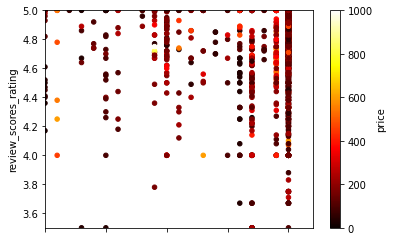

In [55]:
plot = df_none_null.plot.scatter(x="host_response_rate", y="review_scores_rating",
        c="price",colormap='hot')
plot.set_xlim([80,102])
plot.set_ylim([3.5,5])

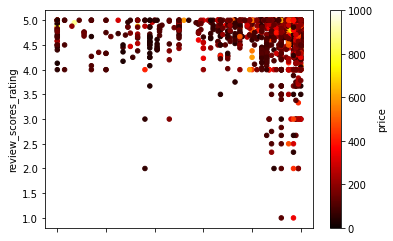

In [56]:
plot = df_none_null.plot.scatter(x="host_acceptance_rate", y="review_scores_rating",
        c="price",colormap='hot')

<AxesSubplot:title={'center':'price'}, xlabel='host_response_time'>

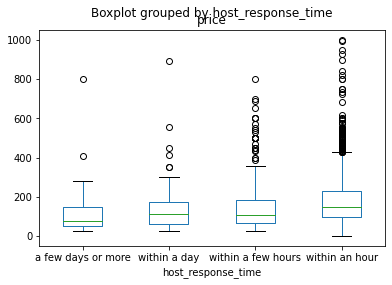

In [57]:
df_none_null.boxplot(by="host_response_time", column=["price"], grid = False)#.set_ylim([3.8,5])

(3.8, 5.0)

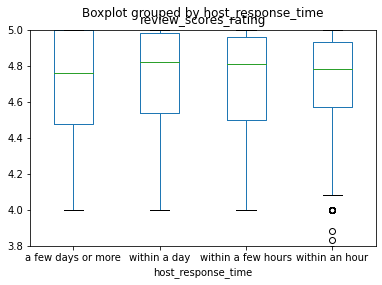

In [58]:
df_none_null.boxplot(by="host_response_time", column=["review_scores_rating"], grid = False).set_ylim([3.8,5])

<AxesSubplot:title={'center':'price'}, xlabel='host_is_superhost'>

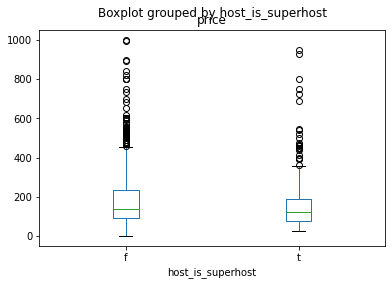

In [59]:
df_none_null.boxplot(by="host_is_superhost", column=["price"], grid = False)#.set_ylim([3.8,5])

(3.8, 5.0)

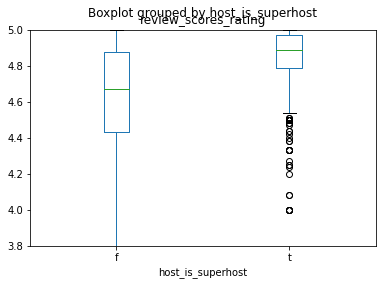

In [60]:
df_none_null.boxplot(by="host_is_superhost", column=["review_scores_rating"], grid = False).set_ylim([3.8,5])

In [61]:
# host_response_time
host_response_time_dummies = pd.get_dummies(df_none_null['host_response_time'],prefix='host_response_time_')
df_none_null = pd.concat([df_none_null,host_response_time_dummies], axis = 1)

# host_is_superhost: t/f to binary
df_none_null['host_is_superhost'] = df_none_null['host_is_superhost'].map(trueFalseToBinary)
# "host_verifications",
df_none_null['host_verifications'] = df_none_null['host_verifications'].map(stringListToCount)
# "host_has_profile_pic" tf to binary
df_none_null['host_has_profile_pic'] = df_none_null['host_has_profile_pic'].map(trueFalseToBinary)
# "host_identity_verified",tf to binary
df_none_null['host_identity_verified'] = df_none_null['host_identity_verified'].map(trueFalseToBinary)

columns_of_interest_hosts = ["price", "review_scores_rating", 
                        "host_number_of_years", "host_response_rate","host_acceptance_rate",
                        # "host_response_time",
                        "host_is_superhost", "host_verifications",
                        #"host_has_profile_pic", "host_identity_verified"
                        ]
df_none_null[columns_of_interest_hosts]

,price,review_scores_rating,host_number_of_years,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications
1,145.0,4.77,12.400000,100,94,1,4
2,169.0,4.79,12.400000,100,94,1,4
3,76.0,4.78,11.980822,100,66,1,8
4,106.0,5.00,11.827397,99,14,1,8
8,111.0,4.30,11.484932,85,97,0,5
...,...,...,...,...,...,...,...
2975,148.0,4.00,2.043836,100,97,0,7
2981,138.0,5.00,0.131507,100,87,0,2
2982,131.0,3.00,0.131507,100,87,0,2
2987,201.0,5.00,8.076712,100,100,1,5


<AxesSubplot:>

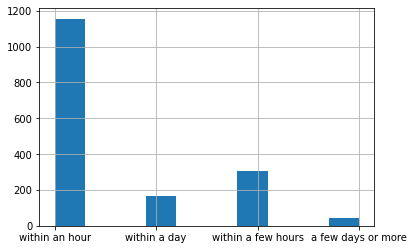

In [62]:
df_none_null['host_response_time'].hist()

<AxesSubplot:>

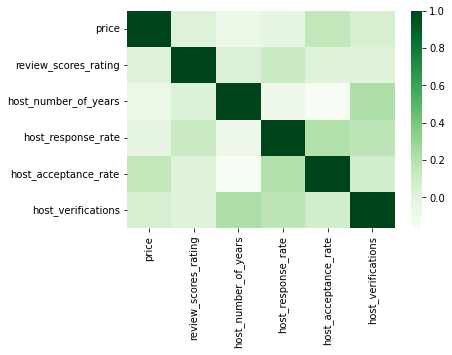

In [63]:
_df_interest = df_none_null[columns_of_interest_hosts]
sns.heatmap(_df_interest.corr(method='spearman'),cmap = 'Greens')

In [64]:
df_none_null['host_is_superhost'].astype('int32').corr(df_none_null['price'], method="kendall")

-0.09224928294488599

In [65]:
df_none_null[columns_of_interest_hosts]

,price,review_scores_rating,host_number_of_years,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications
1,145.0,4.77,12.400000,100,94,1,4
2,169.0,4.79,12.400000,100,94,1,4
3,76.0,4.78,11.980822,100,66,1,8
4,106.0,5.00,11.827397,99,14,1,8
8,111.0,4.30,11.484932,85,97,0,5
...,...,...,...,...,...,...,...
2975,148.0,4.00,2.043836,100,97,0,7
2981,138.0,5.00,0.131507,100,87,0,2
2982,131.0,3.00,0.131507,100,87,0,2
2987,201.0,5.00,8.076712,100,100,1,5


# room features and pricing


/var/folders/89/dlgkzx7s06z_9t0lcl5wtj_w0000gp/T/ipykernel_68494/685513891.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  room_df['room_type'] = room_df['room_type'].map(
/var/folders/89/dlgkzx7s06z_9t0lcl5wtj_w0000gp/T/ipykernel_68494/685513891.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  room_df['availability_30'] = room_df['availability_30']/30.0
/var/folders/89/dlgkzx7s06z_9t0lcl5wtj_w0000gp/T/ipykernel_68494/685513891.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of

<AxesSubplot:>

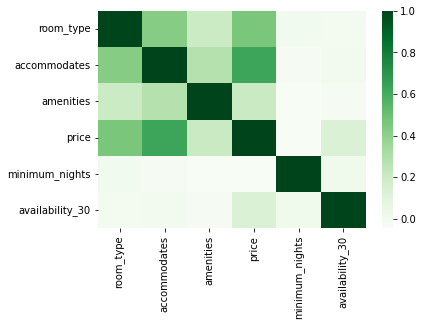

In [66]:
room_features = ["room_type", "accommodates", "amenities", "price", "minimum_nights", "availability_30"]
room_df = df_none_null[room_features]

# "room_type" ['Entire home/apt'4 'Private room'2 'Shared room'1 'Hotel room'3]
room_df['room_type'] = room_df['room_type'].map(
                            {'Entire home/apt':4,
                                'Private room':2,
                                 'Shared room':1,
                                  'Hotel room':3})
                                  
room_df['availability_30'] = room_df['availability_30']/30.0
# "accommodates", pass
#  "amenities", 
room_df['amenities'] = room_df['amenities'].map(stringListToCount).astype('int32')
# "price", pass

sns.heatmap(room_df.corr(), cmap="Greens")

/var/folders/89/dlgkzx7s06z_9t0lcl5wtj_w0000gp/T/ipykernel_68494/2961192653.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reviews['availability_30'] = df_reviews['availability_30']/30.0


<AxesSubplot:>

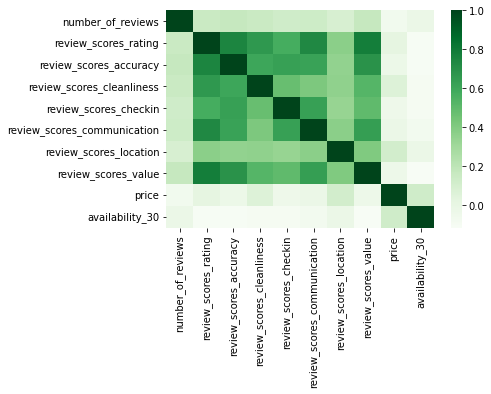

In [67]:
_review_features = [ "number_of_reviews", "review_scores_rating", "review_scores_accuracy",	"review_scores_cleanliness",	"review_scores_checkin",	"review_scores_communication",
                        "review_scores_location",	"review_scores_value", 'price', "availability_30"]
df_reviews= df_none_null[_review_features]
df_reviews['availability_30'] = df_reviews['availability_30']/30.0
sns.heatmap(df_reviews.corr(), cmap="Greens")

/var/folders/89/dlgkzx7s06z_9t0lcl5wtj_w0000gp/T/ipykernel_68494/3783908125.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_availability['availability_30'] = df_availability['availability_30']/30.0
/var/folders/89/dlgkzx7s06z_9t0lcl5wtj_w0000gp/T/ipykernel_68494/3783908125.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_availability['availability_60'] = df_availability['availability_60']/60.0
/var/folders/89/dlgkzx7s06z_9t0lcl5wtj_w0000gp/T/ipykernel_68494/3783908125.py:8: SettingWithCopyWarni

<AxesSubplot:>

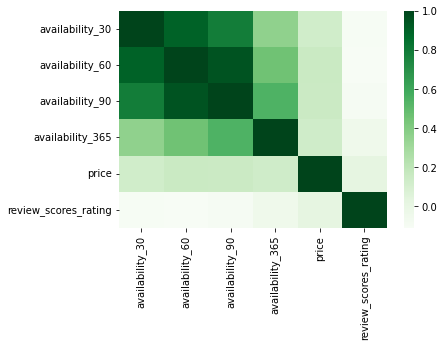

In [68]:
availability_features = ["availability_30",	"availability_60",	"availability_90","availability_365",'price', 'review_scores_rating']
df_availability = df_none_null[availability_features]
# "availability_30",
df_availability['availability_30'] = df_availability['availability_30']/30.0
# "availability_60",
df_availability['availability_60'] = df_availability['availability_60']/60.0
# "availability_90",
df_availability['availability_90'] = df_availability['availability_90']/90.0
# "availability_365", 
df_availability['availability_365'] = df_availability['availability_365']/365.0
sns.heatmap(df_availability.corr(), cmap="Greens")



<AxesSubplot:xlabel='price', ylabel='availability_30'>

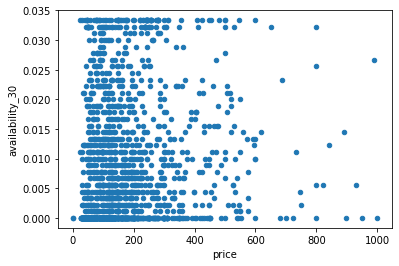

In [69]:
df_availability.plot.scatter(x="price",y="availability_30")#, c="availability_30",colormap='hot' )

<AxesSubplot:xlabel='price', ylabel='review_scores_rating'>

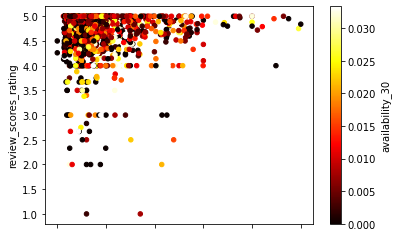

In [70]:
df_availability.plot.scatter(x="price",y="review_scores_rating", c="availability_30",colormap='hot' )

<AxesSubplot:xlabel='price', ylabel='availability_30'>

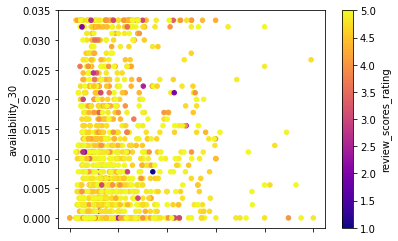

In [71]:
df_availability.plot.scatter(x="price",y="availability_30", c="review_scores_rating",colormap='plasma' )

<AxesSubplot:>

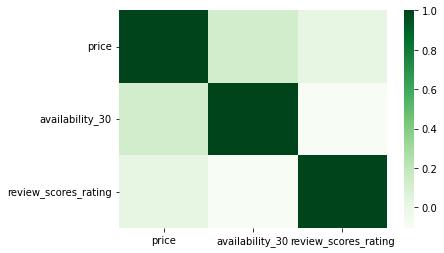

In [72]:
df_test = df_none_null[['price', 'availability_30','review_scores_rating']]
sns.heatmap(df_test.corr(), cmap="Greens")

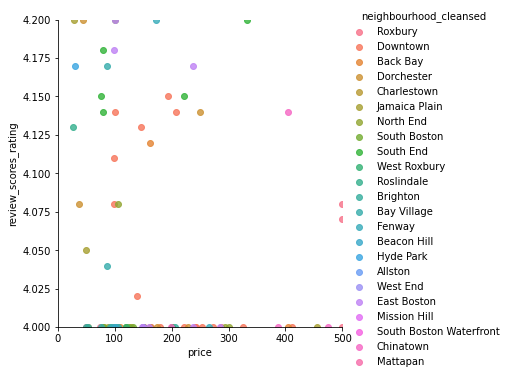

In [73]:
a = sns.lmplot(x='price', y='review_scores_rating', data=df_none_null, hue='neighbourhood_cleansed',fit_reg=False)
a.set(ylim=(4, 4.2))
a.set(xlim=(0, 500))

/Users/jingyu/.pyenv/versions/3.9.6/envs/lab4/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


<AxesSubplot:>

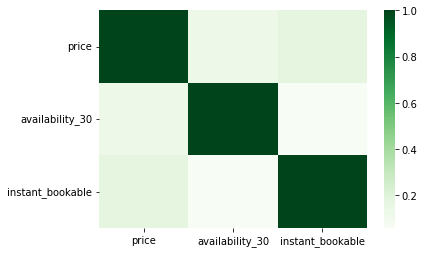

In [74]:
df_test = df_none_null[['price', 'availability_30','instant_bookable']]
df_test.instant_bookable = df_test['instant_bookable'].map(trueFalseToBinary).astype('int32')
sns.heatmap(df_test.corr(), cmap="Greens")

# patterns
- hosts with longer years doesn't necessarily have the best reviews ratings; lowest years tend to be more spread out
- hosts with more years tend to focus more on average priced units, where as beginner hosts are spread out on pricing.
- neighborhoods do vary quite significantly in pricing

## host features and pricing
- higher response rates and higher acceptance rate seem to command higher pricing?
- hosts with faster response times are commanding higher pricings in all quantiles ; but not necessarily better review scores
- super hosts offer a much condensed range of pricing and lower pricings; and have a tighter range of review scores; and higher median review scores
- "host_has_profile_pic", "host_identity_verified" are useless; lacking variance

# price and room features
- price ~ room type
- price ~ number of amenaties
- price ~ accommodations

# price and reviews
- location and cleaniness > others

# price and availability
- price ~ availability

# Combined: Processing all variables of concern

In [75]:
features_none_null = ["id","host_id","host_since","host_response_rate","host_acceptance_rate",
                        "host_response_time",
                        "host_is_superhost", "host_verifications",
                        # "host_has_profile_pic", "host_identity_verified",
                        # "neighbourhood_cleansed",
                        "latitude", "longitude",
                        "room_type", "accommodates", "amenities", "price", "minimum_nights", 
                        "availability_30",	"availability_60",	"availability_90","availability_365", 
                        "number_of_reviews", "review_scores_rating", 
                        "review_scores_accuracy",	"review_scores_cleanliness",	"review_scores_checkin",	"review_scores_communication",
                        "review_scores_location",	"review_scores_value",
                        "instant_bookable", 
                        ]
reviews_data_path = "feather/reviews.feather"
listings_data_path = "feather/listings.feather"
calendar_data_path = "feather/calendar.feather"
reviews_data = pd.read_feather(reviews_data_path)
listings_data = pd.read_feather(listings_data_path)
calendar_data = pd.read_feather(calendar_data_path)

# reviews_data_path = "data/reviews.csv"
# listings_data_path = "data/listings.csv"
# calendar_data_path = "data/calendar.csv"

# reviews_data = pd.read_csv(reviews_data_path)
# listings_data = pd.read_csv(listings_data_path)
# calendar_data = pd.read_csv(calendar_data_path)

reviews_data = reviews_data.dropna()

df_none_null = listings_data.copy(deep = True)[features_none_null]

print("before droppign rows with null columns: ", df_none_null.shape)
for col in features_none_null:
    df_none_null = df_none_null[df_none_null[col].notna()]
print("after dropping rows with null columns: ", df_none_null.shape)



## most null columns - host_response_rate/accpetance rate, review_scores




reference_date = datetime.datetime(2021,7,12)
# adding custom: host_number_of_years
host_number_of_years = [(reference_date - datetime.datetime.strptime(i, '%Y-%m-%d')).days/365
                        for i in df_none_null['host_since']]
df_none_null["host_number_of_years"] = host_number_of_years
df_none_null['price'] = df_none_null['price'].map(lambda x:float(x[1:].replace(',', ''))).astype('int32')


# host reposnse rate; remove % sign, convert to integer
df_none_null['host_response_rate'] = df_none_null['host_response_rate'].map(percentToInt).astype('int32')
#  host_acceptance_rate:
df_none_null['host_acceptance_rate'] = df_none_null['host_acceptance_rate'].map(percentToInt).astype('int32')

# TODO host_response_time; arbitrary or one-hot
# df_none_null['host_response_time']= df_none_null['host_response_time'].map({
#     'within an hour':1, 'within a day':3, 'within a few hours':2,
#        'a few days or more':4
# })
host_response_time_dummies = pd.get_dummies(df_none_null['host_response_time'],prefix='host_response_time')
df_none_null = pd.concat([df_none_null,host_response_time_dummies], axis = 1)

# host_is_superhost: t/f to binary
df_none_null['host_is_superhost'] = df_none_null['host_is_superhost'].map(trueFalseToBinary).astype('int32')
# "host_verifications",
df_none_null['host_verifications'] = df_none_null['host_verifications'].map(stringListToCount).astype('int32')
# # "host_has_profile_pic" tf to binary
# df_none_null['host_has_profile_pic'] = df_none_null['host_has_profile_pic'].map(trueFalseToBinary).astype('int32')
# # "host_identity_verified",tf to binary
# df_none_null['host_identity_verified'] = df_none_null['host_identity_verified'].map(trueFalseToBinary).astype('int32')

# TODO "neighbourhood_cleansed" or leave out - lat long enough

# "latitude" pass
# "longitude", pass

# "room_type" ['Entire home/apt'4 'Private room'2 'Shared room'1 'Hotel room'3]
df_none_null['room_type'] = df_none_null['room_type'].map(
                            {'Entire home/apt':4,
                                'Private room':2,
                                 'Shared room':1,
                                  'Hotel room':3})

# "accommodates", pass
#  "amenities", 
df_none_null['amenities'] = df_none_null['amenities'].map(stringListToCount).astype('int32')
# "price", pass

# TODO "minimum_nights", to categorical? 3 categories [short medium long?]
# df_none_null['minimum_nights'] = df_none_null['minimum_nights']

# "availability_30",
df_none_null['availability_30'] = df_none_null['availability_30']/30.0
# "availability_60",
df_none_null['availability_60'] = df_none_null['availability_60']/60.0
# "availability_90",
df_none_null['availability_90'] = df_none_null['availability_90']/90.0
# "availability_365", 
df_none_null['availability_365'] = df_none_null['availability_365']/365.0

# "number_of_reviews" pass,

# all pass
# "review_scores_rating", 
# "review_scores_accuracy",
# "review_scores_cleanliness",
# 	"review_scores_checkin",	
# "review_scores_communication",
# "review_scores_location",
# 	"review_scores_value",

# "instant_bookable", 
df_none_null['instant_bookable'] = df_none_null['instant_bookable'].map(trueFalseToBinary).astype('int32')


df_none_null = df_none_null.drop(['host_response_time', 'host_since'], axis=1)

before droppign rows with null columns:  (3043, 28)
after dropping rows with null columns:  (1678, 28)


In [76]:
df_none_null.describe()

,id,host_id,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications,latitude,longitude,room_type,accommodates,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,host_number_of_years,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour
count,1.678000e+03,1.678000e+03,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.00000,...,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000,1678.000000
mean,2.806438e+07,1.083830e+08,95.119785,86.871275,0.382598,5.504768,42.336473,-71.080537,3.336114,3.36174,...,4.833284,4.800900,4.756454,4.603796,0.375447,5.509854,0.025030,0.099523,0.184148,0.691299
std,1.537160e+07,1.177168e+08,14.470436,21.964603,0.486166,2.063029,0.027580,0.030593,0.940201,2.35990,...,0.372422,0.423228,0.353771,0.434780,0.484382,2.859154,0.156262,0.299453,0.387720,0.462095
min,5.506000e+03,7.969000e+03,0.000000,0.000000,0.000000,1.000000,42.235330,-71.172410,1.000000,1.00000,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.073973,0.000000,0.000000,0.000000,0.000000
25%,1.543622e+07,1.558399e+07,97.000000,86.000000,0.000000,4.000000,42.318602,-71.095443,2.000000,2.00000,...,4.840000,4.800000,4.670000,4.500000,0.000000,2.964384,0.000000,0.000000,0.000000,0.000000
50%,2.861089e+07,4.800549e+07,100.000000,97.000000,0.000000,6.000000,42.344350,-71.071175,4.000000,2.00000,...,4.945000,4.940000,4.870000,4.710000,0.000000,5.695890,0.000000,0.000000,0.000000,1.000000
75%,4.239783e+07,2.052698e+08,100.000000,99.000000,1.000000,7.000000,42.354447,-71.061395,4.000000,4.00000,...,5.000000,5.000000,5.000000,4.860000,1.000000,7.164384,0.000000,0.000000,0.000000,1.000000
max,5.073173e+07,4.072222e+08,100.000000,100.000000,1.000000,10.000000,42.389600,-70.997810,4.000000,16.00000,...,5.000000,5.000000,5.000000,5.000000,1.000000,12.410959,1.000000,1.000000,1.000000,1.000000


In [77]:
print(df_none_null.dtypes) # check all numerical now

id                                         int64
host_id                                    int64
host_response_rate                         int32
host_acceptance_rate                       int32
host_is_superhost                          int32
host_verifications                         int32
latitude                                 float64
longitude                                float64
room_type                                  int64
accommodates                               int64
amenities                                  int32
price                                      int32
minimum_nights                             int64
availability_30                          float64
availability_60                          float64
availability_90                          float64
availability_365                         float64
number_of_reviews                          int64
review_scores_rating                     float64
review_scores_accuracy                   float64
review_scores_cleanl

# PCA / tSNE analysis ; dimensionality reduction
# lacking interpretability; discard

                                            PC0       PC1       PC2       PC3  \
host_response_rate                    -0.049551 -0.263766 -0.255527 -0.481430   
host_acceptance_rate                  -0.014542 -0.288074 -0.279784  0.036379   
host_is_superhost                     -0.198649 -0.005292 -0.029560 -0.231985   
host_verifications                    -0.029361 -0.048182 -0.020054 -0.042118   
latitude                               0.044588 -0.154570 -0.081940  0.025369   
longitude                              0.054623 -0.153438 -0.039238 -0.007494   
room_type                              0.030418 -0.177247 -0.118169  0.243113   
accommodates                          -0.002006 -0.168971 -0.071557  0.313355   
amenities                             -0.080997 -0.154112 -0.059230  0.091875   
minimum_nights                         0.008487  0.167113  0.118226  0.084249   
availability_30                        0.155099 -0.277680  0.390423 -0.085808   
availability_60             

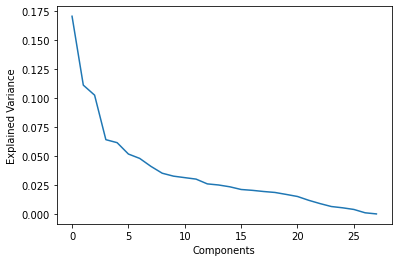

In [78]:
df = df_none_null.drop(['price', 'id','host_id'], axis=1)
pca = PCA(0.9)
pca.fit(df)

# You must normalize the data before applying the fit method
df_normalized=(df - df.mean()) / df.std()
pca = PCA( n_components=df.shape[1])
pca.fit(df_normalized)

# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
index=df.columns)
print(loadings)

plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

In [79]:
lm = LinearRegression()
df = df_none_null.drop(['price', 'id','host_id'], axis=1)
df_label = df_none_null['price']
X_train, X_test, y_train, y_test = train_test_split(df, df_label, test_size=0.1, random_state=101)
lm.fit(X_train,y_train)


LinearRegression()

In [80]:
'''Get Predictions & Print Metrics'''
predicts = lm.predict(X_test)

print("""
        Mean Squared Error: {}
        R2 Score: {}
        Mean Absolute Error: {}
     """.format(
        np.sqrt(metrics.mean_squared_error(y_test, predicts)),
        r2_score(y_test,predicts),
        mean_absolute_error(y_test,predicts)
        ))


        Mean Squared Error: 181.40625744504993
        R2 Score: 0.4005343185904626
        Mean Absolute Error: 82.16617474215833
     


In [81]:
for i, coef in enumerate(np.array(lm.coef_)):
    print(df.columns[i],"\t", coef)

host_response_rate 	 -1.0497145745637113
host_acceptance_rate 	 -0.17758939770713567
host_is_superhost 	 -20.215378717680117
host_verifications 	 -5.778294978846259
latitude 	 592.9121907970483
longitude 	 328.08355611362384
room_type 	 14.271152641549431
accommodates 	 33.538672003182725
amenities 	 0.2841335059676839
minimum_nights 	 -0.2011576308953522
availability_30 	 35.2098522364827
availability_60 	 -9.980252755515448
availability_90 	 -2.593503722636783
availability_365 	 -3.254237904829131
number_of_reviews 	 -0.052031093782088554
review_scores_rating 	 30.929291941146733
review_scores_accuracy 	 -19.168228344798273
review_scores_cleanliness 	 -5.775260302620489
review_scores_checkin 	 -8.370237293350597
review_scores_communication 	 4.087816897185679
review_scores_location 	 35.95662906465751
review_scores_value 	 -25.46706487059151
instant_bookable 	 30.907199850995735
host_number_of_years 	 -3.4621806661363435
host_response_time_a few days or more 	 -88.88670684786676
host

In [82]:
'''Get Predictions & Print Metrics'''
predicts = lm.predict(X_test)

print("""
        Mean Squared Error: {}
        R2 Score: {}
        Mean Absolute Error: {}
     """.format(
        np.sqrt(metrics.mean_squared_error(y_test, predicts)),
        r2_score(y_test,predicts),
        mean_absolute_error(y_test,predicts)
        ))


        Mean Squared Error: 181.40625744504993
        R2 Score: 0.4005343185904626
        Mean Absolute Error: 82.16617474215833
     


In [258]:
error_airbnb = pd.DataFrame({
        'Actual Values': np.array(y_test).flatten(),
        'Predicted Values': predicts.flatten()})

error_airbnb

,Actual Values,Predicted Values
0,105,106.599604
1,248,205.634891
2,508,425.935326
3,98,163.825479
4,66,48.117869
...,...,...
163,200,222.774671
164,222,308.679575
165,314,404.309423
166,474,243.258894


/Users/jingyu/.pyenv/versions/3.9.6/envs/lab4/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


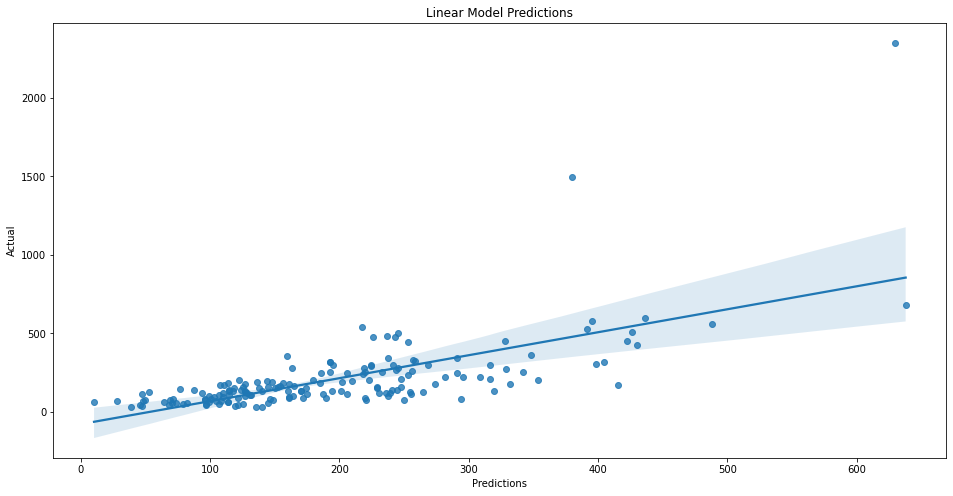

In [259]:
plt.figure(figsize=(16,8))
sns.regplot(predicts,y_test)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Linear Model Predictions")
plt.grid(False)
plt.show()

# Above model doesn't tell what should be a good pricing; just how it would be priced.
for example, super host has a negative coefficient;

# predicting availability

In [260]:
lm = LinearRegression()
df = df_none_null.drop(["availability_30",	"availability_60",	"availability_90","availability_365", 'id','host_id'], axis=1)
df_label = df_none_null['availability_30']
X_train, X_test, y_train, y_test = train_test_split(df, df_label, test_size=0.1, random_state=101)
lm.fit(X_train,y_train)

'''Get Predictions & Print Metrics'''
predicts = lm.predict(X_test)

print("""
        Mean Squared Error: {}
        R2 Score: {}
        Mean Absolute Error: {}
     """.format(
        np.sqrt(metrics.mean_squared_error(y_test, predicts)),
        r2_score(y_test,predicts),
        mean_absolute_error(y_test,predicts)
        ))
        
for i, coef in enumerate(np.array(lm.coef_)):
    print(df.columns[i],"\t", coef)


        Mean Squared Error: 0.33235225753517106
        R2 Score: -0.09935602196296078
        Mean Absolute Error: 0.271556988962406
     
host_response_rate 	 -0.004692423024818082
host_acceptance_rate 	 -0.0016649270766318385
host_is_superhost 	 -0.04968038748460529
host_verifications 	 0.0004884535704751405
latitude 	 0.671385829685784
longitude 	 0.5286675954687206
room_type 	 -0.02639871070431522
accommodates 	 -0.001923061916286018
amenities 	 0.00037424331705987875
price 	 2.916604239360955e-05
minimum_nights 	 0.00011799381084248077
number_of_reviews 	 0.00013780151315599706
review_scores_rating 	 0.014334019225329448
review_scores_accuracy 	 -0.017529618113611322
review_scores_cleanliness 	 -0.020819230017656048
review_scores_checkin 	 -0.056153432235038846
review_scores_communication 	 0.0288198186536977
review_scores_location 	 0.03951099519904826
review_scores_value 	 -0.06704245314953981
instant_bookable 	 0.044458896847310206
host_number_of_years 	 -0.005957077943821128

/Users/jingyu/.pyenv/versions/3.9.6/envs/lab4/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


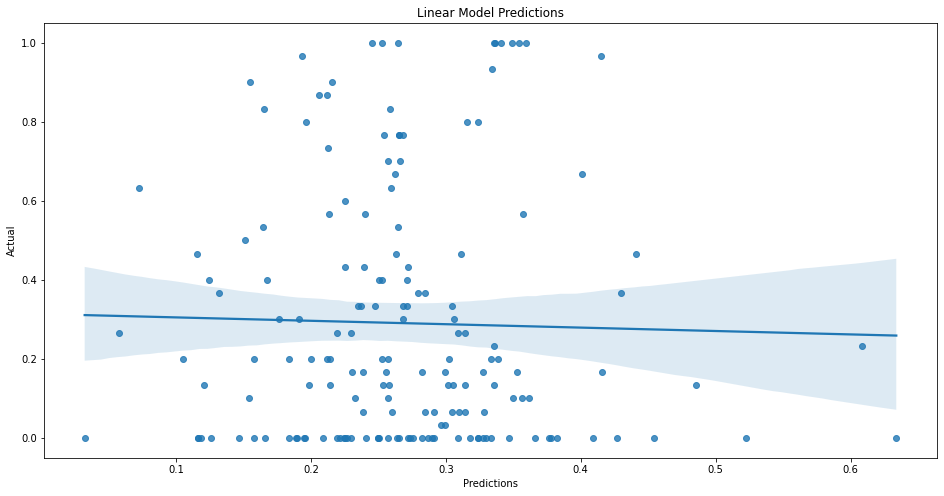

In [261]:
plt.figure(figsize=(16,8))
sns.regplot(predicts,y_test)
plt.xlabel('Predictions')
plt.ylabel('Actual')
plt.title("Linear Model Predictions")
plt.grid(False)
plt.show()

In [ ]:
r2 score - 0.4 ;  -0.09